In [40]:
import gc

import torch
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer
from torch import nn
import pandas as pd
from nltk.corpus import stopwords
import re
from rank_bm25 import BM25Okapi
import nltk
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm
from transformers import DistilBertTokenizerFast, AdamW, DistilBertConfig
from transformers import DistilBertModel, DistilBertPreTrainedModel
from torch.utils.data import DataLoader


class distilBert(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-cased')
        self.qa_outputs = nn.Linear(768, 2)
        self.dropout = nn.Dropout(0.3)
        self.post_init()

    def get_position_embeddings(self) -> nn.Embedding:
        return self.distilbert.get_position_embeddings()

    def resize_position_embeddings(self, new_num_position_embeddings: int):
        self.distilbert.resize_position_embeddings(new_num_position_embeddings)

    def forward(self,
                input_ids=None,
                attention_mask=None,
                head_mask=None,
                inputs_embeds=None,
                start_positions=None,
                end_positions=None,
                output_attentions=None,
                output_hidden_states=None, ):
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        hidden_states = distilbert_output[0]

        hidden_states = self.dropout(hidden_states)
        logits = self.qa_outputs(hidden_states)
        start_logits, end_logits = logits.split(1, dim=-1)
        a, b = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        outputs = (start_logits, end_logits,) + distilbert_output[1:]
        if start_positions is not None and end_positions is not None:
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            outputs = (total_loss,) + outputs

        return {
            'loss': total_loss,
            'start_logits': start_logits,
            'end_logits': end_logits
        }


def get_from_csv(path):
    context = []
    question = []
    answer = []
    with open(path) as f:
        dataset = f.readlines()
        for x in dataset:
            data = x.split(' ||| ')
            answer.append(data[2].strip())
            question.append(data[1])
            context.append(data[0].replace('<s>', ''))
    dataset = pd.DataFrame(columns=['answer', 'question', 'context'])
    for c, x in enumerate(answer):
        new_row = pd.DataFrame({'answer': answer[c], 'question': question[c], 'context': context[c]}, index=[0])
        dataset = pd.concat([dataset, new_row], ignore_index=True)
    return dataset


def preprocess(text):
    stop_words = set(stopwords.words("english"))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    return text

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encoding):
        self.encoding = encoding

    def __getitem__(self, idx):
        input_ids = self.encoding['input_ids'][idx]
        attention_mask = self.encoding['attention_mask'][idx]
        answer_start = int(self.encoding['answers'][idx]['answer_start'])
        answer_end = int(self.encoding['answers'][idx]['answer_end'])
        start_position = self.encoding[idx].char_to_token(idx, answer_start)
        end_position = self.encoding[idx].char_to_token(idx, answer_end)

        if start_position is None:
            # start_position = tokenizer.model_max_length
            start_position = 0

        shift = 1
        while end_position is None:
            end_position = self.encoding[idx].char_to_token(idx, answer_end - shift)
            if start_position == 0:
                end_position = 0
        sample = {'input_ids': input_ids, 'attention_mask': attention_mask, "start_positions": start_position,
                  "end_positions": end_position}
        return sample

    def __len__(self):
        return len(self.encoding)


def collate_batch(batch):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []
    i = 0
    for x in batch:
        input_ids.append(x['input_ids'])
        attention_masks.append(x['attention_mask'])
        start_positions.append(x['start_positions'])
        end_positions.append(x['end_positions'])

    # return {'input_ids':input_ids,'attention_masks':attention_masks,'start_positions':start_positions,'end_positions':end_positions}
    return input_ids, attention_masks, start_positions, end_positions





In [ ]:

def bm25(df_dic):
    dataset = pd.DataFrame(columns=['answer', 'question', 'context'])
    for i in range(0, len(df_dic) - 1):
        context = df_dic.loc[i][2]
        answer = df_dic.loc[i][0]
        question = df_dic.loc[i][1]
        sentences = context.split('</s>')[:-1]
        corpus_sent = []

        for sent in sentences:
            preprocessedsent = preprocess(sent)
            corpus_sent.append(preprocessedsent)
        else:
            corpus_sent.append(" ")

        query = preprocess(question)

        tokenized_query = query.split(" ")

        tokenized_corpus_abstract = [doc.split(" ") for doc in corpus_sent]

        bm25_abstract = BM25Okapi(tokenized_corpus_abstract)
        doc_scores_abstracts = bm25_abstract.get_scores(tokenized_query)

        doc_scores = doc_scores_abstracts

        score_dict = dict(zip([x + '</s>' for x in sentences], doc_scores))

        doc_ranking = sorted(score_dict, reverse=True)
        context = ''.join(doc_ranking)
        start_idx = context.find(answer)
        new_row = pd.DataFrame({'answer': answer, 'question': question, 'context': context, 'start': start_idx},
                               index=[0])
        dataset = pd.concat([dataset, new_row], ignore_index=True)
    # new_row.to_pickle('dataset.pkl')

    return dataset




In [ ]:


def add_end_idx(answers, contexts, starts):
    new_answers = []
    for answer, context, start in tqdm(zip(answers, contexts, starts)):
        gold_text = answer
        start_idx = start
        end_idx = start_idx + len(gold_text)
        answer_start = start_idx

        if context[int(start_idx):int(end_idx)] == gold_text:
            answer_end = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx - n:end_idx - n] == gold_text:
                    answer_start = start_idx - n
                    answer_end = end_idx - n
        answer = {'text': gold_text, 'answer_start': answer_start, 'answer_end': answer_end}
        new_answers.append(answer)
    return new_answers


def prep_data(dataset):
    questions = dataset['question']
    contexts = dataset['context']
    answers = add_end_idx(
        dataset['answer'],
        contexts,
        dataset['start']
    )
    return {
        'question': questions,
        'context': contexts,
        'answer': answers
    }



In [41]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
dataset = get_from_csv('/home/kuro/PycharmProjects/sequence_tagging/NLP2/data/train.txt')
rank = bm25(dataset)
del dataset
gc.collect()
dataset = prep_data(rank)
questions = dataset['question'].to_list()
contexts = dataset['context'].to_list()
answers = dataset['answer']
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
train_encoding = tokenizer(contexts, questions, truncation=True, padding=True, max_length=512)
train_encoding['answers'] = answers
dataset = Dataset(train_encoding)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model = distilBert(DistilBertConfig())
model.to(device)
model.train()
model = torch.load('/home/kuro/PycharmProjects/sequence_tagging/qa-bert')
model.to(device)
model.eval()
optim = AdamW(model.parameters(), lr=5e-5)
loss_fct = CrossEntropyLoss()
training_epoch = 1
loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
accs=[]
losses=[]
for epoch in range(50):
    loop = tqdm(loader)
    for a,b,c,d in loop:
        acc=[]
        optim.zero_grad()
        input_ids = torch.as_tensor(a).to(device)
        attention_mask = torch.as_tensor(b).to(device)
        start_positions =torch.as_tensor( c).to(device)
        end_positions = torch.as_tensor(d).to(device)

        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        start_pred = torch.argmax(outputs['start_logits'],dim=1)
        end_pred = torch.argmax(outputs['end_logits'],dim=1)
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        accuracy = sum(acc)/len(acc)
        accs.append(accuracy)
        loss = outputs['loss']
        losses.append(loss)
        loss.backward()
        optim.step()
        print(f'Epoch : {epoch} loss : {loss.item()} accuracy: {accuracy}')
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

[nltk_data] Downloading package stopwords to /home/kuro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kuro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kuro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


KeyboardInterrupt: 

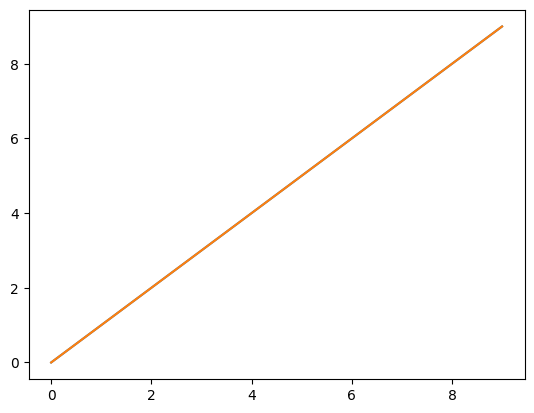

In [44]:
plt.plot(accs, [x for x in range(len(accs))])
plt.plot(loss, [x for x in range(len(losses))])
plt.savefig('evaluation')

In [ ]:

dataset = get_from_csv('/home/kuro/PycharmProjects/sequence_tagging/NLP2/data/val.txt')
rank = bm25(dataset)
del dataset
gc.collect()
dataset = prep_data(rank)
questions = dataset['question'].to_list()
contexts = dataset['context'].to_list()
answers = dataset['answer']
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
train_encoding = tokenizer(contexts, questions, truncation=True, padding=True, max_length=512)
train_encoding['answers'] = answers
dataset = Dataset(train_encoding)


In [ ]:
len(answers)

In [ ]:
vall_loss = []
vall_acc = []
loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
acc = []
loss = []
for epoch in range(50):
    loop = tqdm(loader)
    for a, b, c, d in loop:
        with torch.no_grad():
            input_ids = torch.as_tensor(a).to(device)
            attention_mask = torch.as_tensor(b).to(device)
            start_positions = torch.as_tensor(c).to(device)
            end_positions = torch.as_tensor(d).to(device)

            outputs = model(input_ids, attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)

            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            acc.append(((start_pred == start_positions).sum() / len(start_pred)).item())
            acc.append(((end_pred == end_positions).sum() / len(end_pred)).item())

            loss = outputs['loss']
            vall_loss.append(loss.item())
            print(f'Epoch {epoch} loss {loss.item()}')
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())


In [ ]:

plt.plot(acc, [x for x in range(0, len(acc))])
plt.plot(vall_loss, [x for x in range(0, len(vall_loss))])
plt.savefig('evaluation')
plt.show()